In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import math
import random
import os
import re
import cv2
from skimage.transform import resize
import csv
from functools import partial
from tqdm import tqdm

from os import listdir
from os.path import isfile, join
from math import isnan

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import sklearn.metrics.pairwise
from sklearn.metrics import silhouette_score

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.widgets import Slider, Button

import ipyplot
import io
import urllib.request

from IPython.display import HTML, Javascript, display
import ipywidgets as widgets
from ipywidgets import interact, Layout, Button, GridBox, ButtonStyle

w = widgets.IntSlider()
uploader = widgets.FileUpload(
    accept='*.csv',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False,  # True to accept multiple files upload else False
    description='Upload file',
    style=ButtonStyle(button_color='lightblue')
)

display(uploader)

# def run_all(ev):
#     display(Javascript('IPython.notebook.execute_cells_below()'))
#     #display(Javascript("Jupyter.notebook.execute_cell(2)"))

# button = widgets.Button(description="Create next input")
# button.on_click(run_all)
# display(button)

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

FileUpload(value={}, accept='*.csv', description='Upload file', style=ButtonStyle(button_color='lightblue'))

In [6]:
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))
    #display(Javascript("Jupyter.notebook.execute_cell(2)"))

button = widgets.Button(description="Launch Andromeda",
                       style=ButtonStyle(button_color='lightblue'))
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description='Launch Andromeda', style=ButtonStyle(button_color='lightblue'))

In [7]:
try:    
    input_file = list(uploader.value.values())[0]
    content = input_file['content']
    content = io.StringIO(content.decode('utf-8'))
    df = pd.read_csv(content)
    #df.rename(columns = {'Image_Label':'Name'}, inplace=True)
    df.set_index('Image_Label', inplace=True)

    label_names = df.index.tolist()
    image_paths = {}
    for name in label_names:
        image_paths[name] = df['Image_Link'][name]

    df = df.loc[:, ~df.columns.isin(['Image_Link','Species','User','Date','Time','Annotations','Hex_Color_Code'])]
    df_numeric = df.select_dtypes(include='number')  #'int32' or 'int64' or 'float32' or 'float64'
    df_numeric = df_numeric.loc[:, (df_numeric != df_numeric.iloc[0]).any()] 
    df_category = df.select_dtypes(exclude='number') #'object'
    normalized_df = (df_numeric - df_numeric.mean()) / df_numeric.std()
    min_weight, max_weight = 0.00001, 0.9999
    init_weight = min_weight  # 1.0/len(normalized_df.columns) # initialize to min to make the sliders easier to use.
    weights = pd.Series(init_weight, index=normalized_df.columns, name="Weight")  # the current weight list
    df_2D = dimension_reduction(normalized_df, weights)   # the current projected data
#     plot_ax = create_plot(df_2D, imgDisplaySize)
#     size_slider = create_size_slider(imgDisplaySize)
#     sliders = create_sliders(weights)
#     size_apply_button = create_size_slider_button(size_slider,plot_ax)

#     inverse_button = create_inverse_button(plot_ax, size_slider, sliders)
#     display(widgets.HBox([inverse_button, create_slider_buttons(sliders,size_slider, plot_ax)
#                           ,create_reset_buttons(plot_ax, size_slider, sliders)]))
#     display(widgets.HBox([size_slider,size_apply_button]))

#     point_attribute = create_checkbox(size_slider, plot_ax)

#     for slider in sliders:
#         slider.style.handle_color = 'lightgreen'
#         display(slider)
except Exception:
    pass

# if uploader.value!={}:     
#     input_file = list(uploader.value.values())[0]
#     content = input_file['content']
#     content = io.StringIO(content.decode('utf-8'))
#     df = pd.read_csv(content)
#     #df.rename(columns = {'Image_Label':'Name'}, inplace=True)
#     df.set_index('Image_Label', inplace=True)

#     label_names = df.index.tolist()
#     image_paths = {}
#     for name in label_names:
#         image_paths[name] = df['Image_Link'][name]

#     df = df.loc[:, ~df.columns.isin(['Image_Link','Species','User','Date','Time','Annotations','Hex_Color_Code'])]
#     df_numeric = df.select_dtypes(include='number')  #'int32' or 'int64' or 'float32' or 'float64'
#     df_numeric = df_numeric.loc[:, (df_numeric != df_numeric.iloc[0]).any()] 
#     df_category = df.select_dtypes(exclude='number') #'object'
#     normalized_df = (df_numeric - df_numeric.mean()) / df_numeric.std()
# else:
#     print("Please upload one csv. file")
    
    
def distance_matrix_HD(dataHDw):  
    """
    Compute the distance matrix for the weighted high-dimensional data using L1 distance function.
    Input HD data should already be weighted.
    
    @parameters:
        dataHDw[pd.df or np.array]: weighted high-dimensional data
    @return[array]: distance matrix for input weighted high-dimensional data
    """
    dist_matrix = sklearn.metrics.pairwise.manhattan_distances(dataHDw)
    return dist_matrix

def distance_matrix_2D(data2D): 
    """
    Compute the distance matrix for 2D projected data using L2 distance function.
    
    @parameters: 
        data2D[pd.df or np.array]: projected 2D data
    @return[np.array]: distance matrix for 2D input data
    """
    dist_matrix = sklearn.metrics.pairwise.euclidean_distances(data2D) 
    return dist_matrix


def stress(distHD, dist2D): 
    """
    Calculate the MDS stress metric between HD and 2D distances.
    @parameters: 
        distHD[np.array]: distance matrix for high-dimensional data
        dist2D[np.array]: distance matrix for 2D data
    @return[float]: stress value
    """
    s = ((distHD-dist2D)**2).sum() / (distHD**2).sum()   # numpy, eliminate sqrt for efficiency
    return s

def compute_mds(dataHDw):  
    """
    apply MDS to high-dimensional data to get 2D data
    @parameters:
        dataHDw[pd.df or np.array]: weighted high-dimensional data
    @return[dataframe]: a dataframe of 2D data 
    """
    distHD = distance_matrix_HD(dataHDw)
    ### Adjust these parameters for performance/accuracy tradeoff
    mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed', n_init=10, max_iter=1000, random_state=3)
    # Reduction algorithm happens here:  data2D is n*2 matrix
    data2D = mds.fit_transform(distHD)
    
    ### Rotate the resulting 2D projection to make it more consistent across multiple runs.
    ### Set the 1st PC to the y axis, plot looks better to spread data vertically with horizontal text labels
    pca = sklearn.decomposition.PCA(n_components=2)
    data2D = pca.fit_transform(data2D)
    data2D = pd.DataFrame(data2D, columns=['y','x'], index=dataHDw.index)
    
    data2D.stress_value = stress(distHD, distance_matrix_2D(data2D))
    return data2D

def dimension_reduction(dataHD, wts): # dataHD, wts -> data2D (pandas)
    """
    apply weights to high-dimensional data then apply MDS to get 2D data
    @parameters:
        dataHD[pd.df or np.array]: original high-dimensional data
    @return[dataframe]: a dataframe of projected 2D data
    """
    ### Normalize the weights to sum to 1
    wts = wts/wts.sum()
    
    ### Apply weights to the HD data 
    dataHDw = dataHD * wts
    
    ### DR algorithm
    data2D = compute_mds(dataHDw)

    ### Compute row relevances as:  data dot weights
    ### High relevance means large values in upweighted dimensions
#     data2D['relevance'] = dataHDw.sum(axis=1)
    return data2D





def new_proposal(current, step, direction):
    return np.clip(current + direction*step*random.random(), 0.00001, 0.9999)

def inverse_DR(dataHD, data2D, curWeights=None): 
    """
    @parameters:
        dataHD[pd.df or np.array]: high-dimensional data
        data2D[pd.df or np.array]: projected 2D data
    @return[pd.Series]: new weights  
    """
    dist2D = distance_matrix_2D(data2D)  # compute 2D distances only once
    col_names = dataHD.columns
    dataHD = dataHD.to_numpy()  # use numpy for efficiency
    row, col = dataHD.shape
    
    if curWeights==None:
        curWeights = np.array([1.0/col]*col)  # default weights = 1/p
    else:
        curWeights = curWeights.to_numpy()
        curWeights = curWeights / curWeights.sum()  # Normalize weights to sum to 1
    newWeights = curWeights.copy()  # re-use this array for efficiency
    
    # Initialize state
    flag = [0]*col         # degree of success of a weight change
    direction = [1]*col  # direction to move a weight, pos or neg
    step = [1.0/col]*col   # how much to change each weight
    
    dataHDw = dataHD * curWeights   # weighted space, re-use this array for efficiency
    distHD = distance_matrix_HD(dataHDw)
    curStress = stress(distHD, dist2D)
    print('Starting stress =', curStress, 'Processing...')

    MAX = 500   # default setting of the number of iterations

    # Try to minorly adjust each weight to see if it reduces stress
    for i in range(MAX):
        for dim in range(col):            
            # Get a new weight for current column
            nw = new_proposal(curWeights[dim], step[dim], direction[dim])
            
            # Scale the weight list such that it sums to 1
            s = 1.0  + nw - curWeights[dim]   # 1.0 == curWeights.sum()
            np.true_divide(curWeights, s, out=newWeights)  # transfers to other array, while doing /
            newWeights[dim] = nw / s
            
            # Apply new weights to HD data
            np.multiply(dataHD, newWeights, out=dataHDw)  # dataHDw = dataHD * newWeights; efficiently reuses dataHDw array
            distHD = distance_matrix_HD(dataHDw)

            # Get the new stress
            newStress = stress(distHD, dist2D)
            
            # If new stress is lower, then update weights and flag this success
            if newStress < curStress:
                temp = curWeights
                curWeights = newWeights
                newWeights = temp   # reuse the old array next iteration
                curStress = newStress
                flag[dim] = flag[dim] + 1
            else:
                flag[dim] = flag[dim] - 1
                direction[dim] = -direction[dim]  # Reverse course
    
            # If recent success, then speed up the step rate
            if flag[dim] >= 5:
                step[dim] = step[dim] * 2
                flag[dim] = 0
            elif flag[dim] <= -5:
                step[dim] = step[dim] / 2
                flag[dim] = 0
                
    print('Solution stress =', curStress, 'Done.')
    return pd.Series(curWeights, index=col_names, name="Weight")

def create_size_slider(imgDisplaySize):
    """
    Create image size adjust slider
    @parameters:
        imgDisplaySize[float]: zoom image displayed size
    @return[widgets slider]: return the slize adjustment slider 
    """

    style = {'description_width': 'initial'}
    size_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=imgDisplaySize, 
                                       description='Adjust image size', style = style, 
                                   continuous_update=False, readout_format='.5f',)
    size_slider.style.handle_color = 'lightblue'
    return size_slider

# sliders for weights
def create_sliders(wts):
    # Create sliders, one for each dimension weight
    sliders = [widgets.FloatSlider(min=min_weight, max=max_weight, step=0.01, value=value, 
                                       description=label, continuous_update=False,
                                   layout=Layout(width='80%', height='20px'),readout_format='.5f')
                   for (label, value) in wts.iteritems()]
#     for slider in sliders:
#         slider.style.handle_color = 'lightgreen'
#         display(slider)
        
    return sliders 

# checkboxes
def create_checkbox(size_slider, ax):
    """
    @return: create the checkbox to toggle the images and titles(image index in the dataframe)  
    """
    title_checkbox = widgets.Checkbox(False, description='Toggle Titles',indent=False,
                                      layout=Layout(width='20%', height='20px'))
    image_checkbox = widgets.Checkbox(True, description='Toggle Images',indent=False,
                                      layout=Layout(width='20%', height='20px'))
    
    def title_check_clicked(x):   
        image = image_checkbox.value
        draw_plot(ax, df_2D, size_slider.value, x, image)
        ax.figure.canvas.draw()
    interact(title_check_clicked, x=title_checkbox)
    
    def image_clicked(x):   
        title = title_checkbox.value
        draw_plot(ax, df_2D, size_slider.value, title, x)
        ax.figure.canvas.draw()
    interact(image_clicked, x=image_checkbox)
    return title_checkbox, image_checkbox

def create_size_slider_button(size_slider, ax): 
    """
    @parameters:
        size_slider: 
        ax:
    @return[button]: return image size adjust button
    """
    size_apply_button = widgets.Button(description='Apply Slider Size',
                                      style=ButtonStyle(button_color='lightblue'))
    def size_slider_button_clicked(change):
        toggle_image = hasattr(ax.dragpoint.artists[0], 'ab')
        toggle_tittle = ax.dragpoint.artists[0].text.get_text() != ''
        draw_plot(ax, df_2D, size_slider.value, toggle_tittle, toggle_image)
        ax.figure.canvas.draw()
    size_apply_button.on_click(size_slider_button_clicked)
    return size_apply_button

# apply slider weights
def create_slider_buttons(sliders, size_slider, ax):    
    apply_button = widgets.Button(description='Apply Slider Weights',style=ButtonStyle(button_color='lightgreen'),
                                  layout=Layout(width='22.7%'))

    # Callback functions
    def apply_button_clicked(change):
        # Use the slider values to recompute the DR and redraw the plot
        global weights, df_2D, imageIndex_path_dict   # Update weights and df_2D globals
        weights = pd.Series([s.value for s in sliders], index=normalized_df.columns, name='Weight')
        df_2D = dimension_reduction(normalized_df, weights)   
        
        # Redraw the plot
        toggle_image = hasattr(ax.dragpoint.artists[0], 'ab')
        toggle_tittle = ax.dragpoint.artists[0].text.get_text() != ''
        draw_plot(ax, df_2D, size_slider.value, toggle_tittle, toggle_image)
        ax.figure.canvas.draw()
    apply_button.on_click(apply_button_clicked)
    

    return apply_button

def create_reset_buttons(ax, size_slider, sliders):
    """
    @return[button]: return reset plot button  
    """  
    reset_button = widgets.Button(description='Reset Plot',style=ButtonStyle(button_color='salmon'))
    def reset_button_clicked(change):
        for s in sliders:
            s.value = init_weight            
        global weights, df_2D, normalized_df   # Update weights and df_2D globals
        weights = pd.Series(init_weight, index=normalized_df.columns, name="Weight")
        df_2D = dimension_reduction(normalized_df, weights)   
        toggle_image = hasattr(ax.dragpoint.artists[0], 'ab')
        toggle_tittle = ax.dragpoint.artists[0].text.get_text() != ''
        # Redraw the plot
        draw_plot(ax, df_2D, size_slider.value, toggle_tittle, toggle_image)
        ax.figure.canvas.draw()
    reset_button.on_click(reset_button_clicked)

    return reset_button

def create_inverse_button(ax, size_slider, sliders, fig_show=False):
    """
    @return[button]: return 'Learn New Weights' and 'Update Projections' buttons
    """
    inverse_button = widgets.Button(description='Apply Moved Observations',
                                    style=ButtonStyle(button_color='darkseagreen'),layout=Layout(width='22.7%'))
#     copy_button = widgets.Button(description='Update Projections',
#                                  style=ButtonStyle(button_color='darkseagreen'))

    def inverse_button_clicked(change):
        # Check minimum number of points moved
        n = sum([i.selected for i in ax.dragpoint.artists])
        if n < 2:
            print('Need to select or move at least 2 points in the plot first.')
            return

        # Get selected data points
        data2Dnew = pd.DataFrame([c.center for c in ax.dragpoint.artists if c.selected], columns=['x','y'], 
                                    index=[c.label for c in ax.dragpoint.artists if c.selected]) 
        global normalized_df
        dataHDpart = normalized_df.loc[data2Dnew.index]

        # Learn new weights
        global weights
        weights = inverse_DR(dataHDpart, data2Dnew)
        
        for i,s in enumerate(sliders):
            s.value = weights[i]

    inverse_button.on_click(inverse_button_clicked)
        
    return inverse_button


class DraggablePoints(object):
    def __init__(self, ax, artists):
        self.ax = ax
        self.artists = artists
        self.current_artist = None
        self.last_selected = None
        ax.selected_text.set_text('Selected: none')
        self.offset = (0, 0)
        # Set up mouse listeners
        ax.figure.canvas.mpl_connect('pick_event', self.on_pick)
        ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        ax.figure.canvas.mpl_connect('button_release_event', self.on_release)

    def on_pick(self, event):
        # When point is clicked on (mouse down), select it and start the drag
        if self.current_artist is None:  # clicking on overlapped points sends multiple events
            self.last_selected = event.artist.index  # event.ind
            self.current_artist = event.artist
            event.artist.selected = True
            event.artist.savecolor = event.artist.get_facecolor()
            event.artist.set_facecolor('green')
            #event.artist.set_alpha(1.0)
            self.ax.selected_text.set_text("Selected: " + event.artist.label)
            x0, y0 = event.artist.center
            self.offset = (x0 - event.mouseevent.xdata), (y0 - event.mouseevent.ydata)

    def on_motion(self, event):
        # When dragging, check if point is selected and valid mouse coordinates
        if (self.current_artist is not None) and (event.xdata is not None) and (event.ydata is not None):
            # Drag the point and its text label
            dx, dy = self.offset
            self.current_artist.center = x0, y0 = event.xdata + dx, event.ydata + dy
            self.current_artist.text.set_position((x0 + self.current_artist.radius, 
                                                   y0 ))
            if self.current_artist.ab:
                self.current_artist.ab.xybox = (x0,y0)
        
    def on_release(self, event):
        # When mouse is released, stop the drag
        self.ax.figure.canvas.draw()
        self.current_artist = None
        

def create_plot(data2D, imgDisplaySize, title=False): 
    """
    @parameters:
        data2D[pd.df or np.array]: projected 2D data
        title[boolean]: toggle tittle or not 
    @return[AxesSubplot]: plotting axes
    """
    # Initialize DR plot figure   
    fig, ax = plt.subplots(figsize= (6,6), dpi=80)
    ax.selected_text = ax.figure.text(0,0.005, 'Selected: none', wrap=True, color='green')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.figure.tight_layout()
#     global imageIndex_path_dict
    
    # Store state data:
    ax.dragpoint = None
    draw_plot(ax, data2D, imgDisplaySize, title)
        
    return ax

def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # return the image
    return image

def image_preprocessing(imgIndex):
    """
    segment images if background is black
    @parameters:
        imgIndex[str]: image index
    @return[np.array(image)]: processed image
    """

    global image_paths
    path = image_paths[imgIndex]
    up_width = 150
    up_height = 150
    up_points = (up_width, up_height)    
    src = url_to_image(path)
    src = cv2.resize(src, up_points, interpolation= cv2.INTER_LINEAR)
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)        
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [r,g,b, alpha]
    processed_img = cv2.merge(rgba,4)

    return processed_img

def draw_plot(ax, data2D, imgSize, title=False, image=True): 
    """
    @parameters:
        ax[AxesSubplot]: plot ax
        data2D[dataframe]: projected 2D dataframe
        title[boolean]: whether toggle title or not
        image[boolean]: whether toggle image or not
        imgSize[float]: zoom parameter of OffsetImage, determine size of displaying images
    """
    labels_df = data2D.index.to_series().apply(lambda x: x.split('/')[0])
    data2D['label'] = labels_df
    label_list = list(set(data2D['label']))
    conversion_dict = {k:v for k,v in zip(label_list,range(len(label_list)))}
    data2D['label_num'] = data2D['label'].replace(conversion_dict)
    ax.clear()
    wid = max(data2D.x.max() - data2D.x.min(), data2D.y.max() - data2D.y.min()) # max range of x,y axes
    if not image:
        cnorm = mpl.colors.Normalize(vmin=data2D.label_num.min(), vmax=data2D.label_num.max())
        
        ax.circles = data2D.apply(axis=1, func=lambda row: 
            mpl.patches.Circle(xy=(row.x, row.y), radius=wid/70, alpha=0.95, label=row.label_num,
                                       color = plt.cm.Set3(cnorm(row.label_num)),picker=True))
        for i,c in enumerate(ax.circles):
            # Store state data:
            c.index, c.label, c.selected = i, data2D.index[i], False
            # Draw circles and text labels in plot
            ax.add_patch(c)
            if title:
                c.text = ax.text(c.center[0]+c.radius, c.center[1], c.label, color='black')
            else:
                c.text = ax.text(c.center[0]+c.radius, c.center[1], "", color='none')
    else:
        ax.circles = []
        for x0, y0, index in zip(data2D.x, data2D.y, data2D.index):
            ax.circles.append(mpl.patches.Circle(xy=(x0, y0), radius=wid*imgSize/3, alpha=0.5, 
                                       color = 'none',picker=True))

        for i,c in enumerate(ax.circles):
            # Store state data:
            c.index, c.label, c.selected = i, data2D.index[i], False
            # Draw circles and text labels in plot
            ax.add_patch(c)
            processed_img = image_preprocessing(c.label)
            img = OffsetImage(processed_img,zoom=imgSize)
            c.ab = AnnotationBbox(img, (c.center[0], c.center[1]), frameon=False)
            ax.add_artist(c.ab)
            if title:
                c.text = ax.text(c.center[0]+c.radius, c.center[1], c.label, color='black')
            else:
                c.text = ax.text(c.center[0]+c.radius, c.center[1], "", color='none')

    # Make plot circles draggable
    ax.dragpoint = DraggablePoints(ax, ax.circles)
    # Clean up the plot 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')
    
imgDisplaySize =0.30

<IPython.core.display.Javascript object>


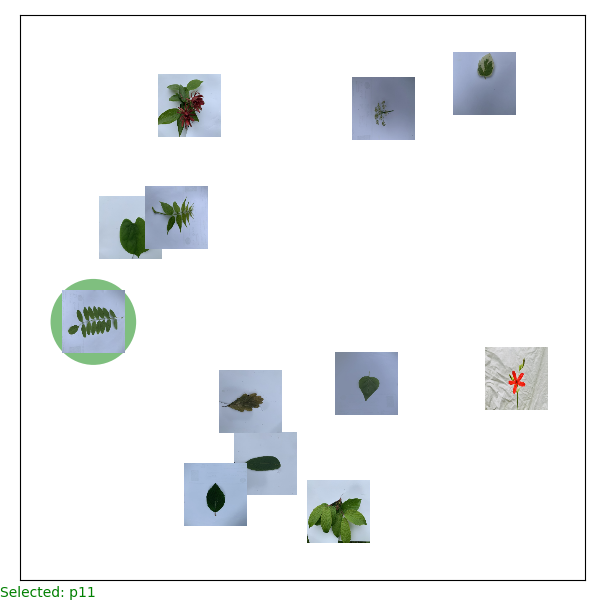

In [8]:
if 'df_2D' in locals():
    plot_ax = create_plot(df_2D, imgDisplaySize)

In [9]:
if 'df_2D' in locals():
    size_slider = create_size_slider(imgDisplaySize)
    sliders = create_sliders(weights)
    size_apply_button = create_size_slider_button(size_slider,plot_ax)

    inverse_button = create_inverse_button(plot_ax, size_slider, sliders)
    display(widgets.HBox([inverse_button, create_slider_buttons(sliders,size_slider, plot_ax)
                          ,create_reset_buttons(plot_ax, size_slider, sliders)]))
    display(widgets.HBox([size_slider,size_apply_button]))

    point_attribute = create_checkbox(size_slider, plot_ax)

    for slider in sliders:
        slider.style.handle_color = 'lightgreen'
        display(slider)

interactive(children=(Checkbox(value=False, description='Toggle Titles', indent=False, layout=Layout(height='2…

interactive(children=(Checkbox(value=True, description='Toggle Images', indent=False, layout=Layout(height='20…

FloatSlider(value=1e-05, continuous_update=False, description='Seconds', layout=Layout(height='20px', width='8…

FloatSlider(value=1e-05, continuous_update=False, description='Lat', layout=Layout(height='20px', width='80%')…

FloatSlider(value=1e-05, continuous_update=False, description='Long', layout=Layout(height='20px', width='80%'…

FloatSlider(value=1e-05, continuous_update=False, description='R1', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='G1', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='B1', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='R2', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='G2', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='B2', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='R3', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='G3', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='B3', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='Per1', layout=Layout(height='20px', width='80%'…

FloatSlider(value=1e-05, continuous_update=False, description='Per2', layout=Layout(height='20px', width='80%'…

FloatSlider(value=1e-05, continuous_update=False, description='Per3', layout=Layout(height='20px', width='80%'…

FloatSlider(value=1e-05, continuous_update=False, description='Contour_Area', layout=Layout(height='20px', wid…

FloatSlider(value=1e-05, continuous_update=False, description='Width', layout=Layout(height='20px', width='80%…

FloatSlider(value=1e-05, continuous_update=False, description='Height', layout=Layout(height='20px', width='80…

FloatSlider(value=1e-05, continuous_update=False, description='Aspect_Ratio', layout=Layout(height='20px', wid…

FloatSlider(value=1e-05, continuous_update=False, description='Extent', layout=Layout(height='20px', width='80…

FloatSlider(value=1e-05, continuous_update=False, description='Solidity', layout=Layout(height='20px', width='…